# Vehicle Detection Project


## Objective
To draw some boxes on cars.



### First: plotting functions

In [1]:
# First, define some handy functions for development and visualisation.
import cv2
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
%matplotlib inline

# Define video function
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def create_video( pipeline_in, input_video, output_video ):
    # Process video
    video = VideoFileClip( input_video )
    video_processed = video.fl_image( pipeline_in )
    %time video_processed.write_videofile( output_video, audio=False )
    
# Define handy side by side plot function
def plot( image1, image2, title2):
    # Plot
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title('Original', fontsize=30)
    ax1.axis('off')
    ax2.imshow(image2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return ax2

# Define draw boxes function
def draw_boxes(image, boxes, colour=(0, 0, 255), thickness=6):
    # Copy image
    draw_image = np.copy(image)
    
    # Draw each bounding box
    for box in boxes:
        cv2.rectangle(draw_image, box[0], box[1], colour, thickness)
    return draw_image

def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    return ax


### Next: Create feature extraction functions

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# Define a function to compute spatial histogram features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             

    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    
    # Return the feature vector
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    

# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    features = []

    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
    
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
    
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Append the new feature vector to the features list
    features.append(np.concatenate((spatial_features, hist_features)))

    #9) Return concatenated array of features
    return features


## Test our functions

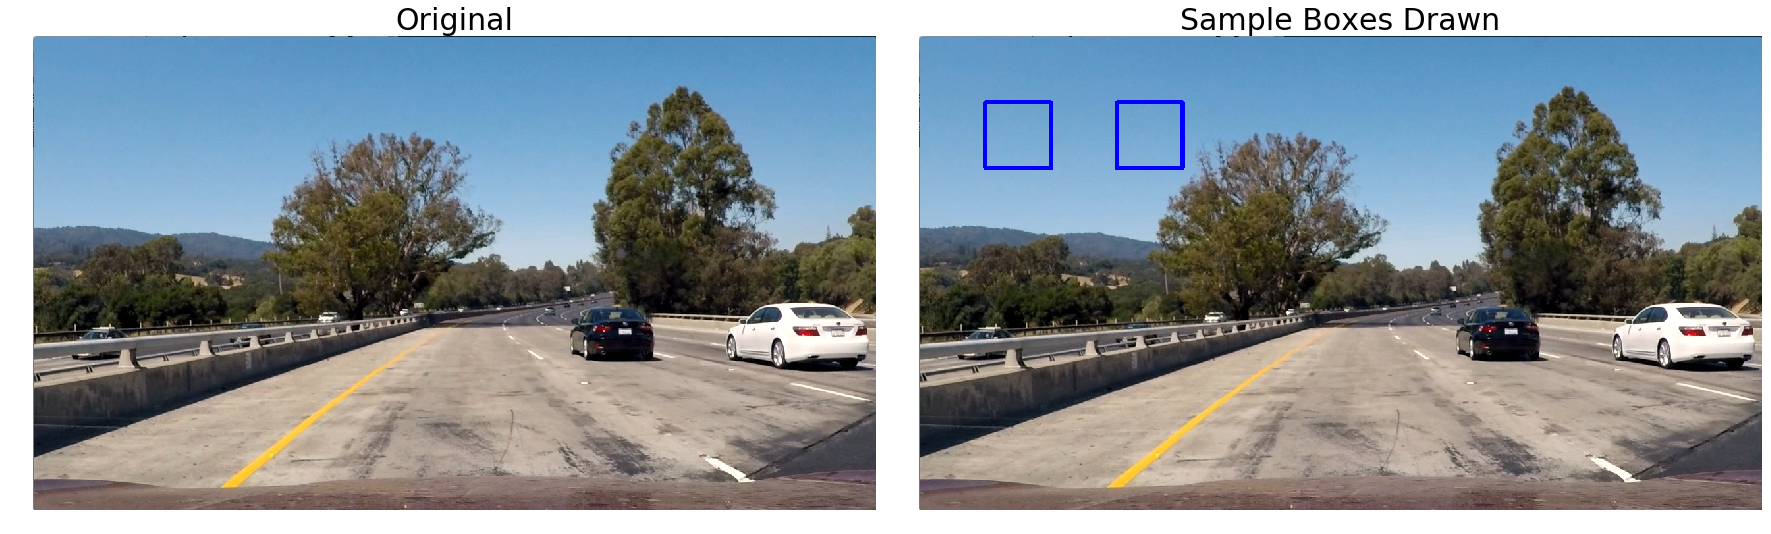

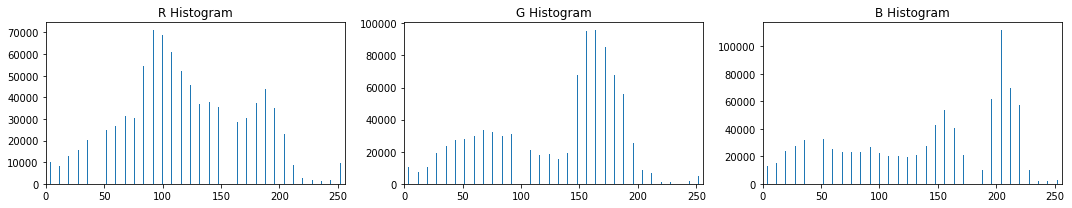

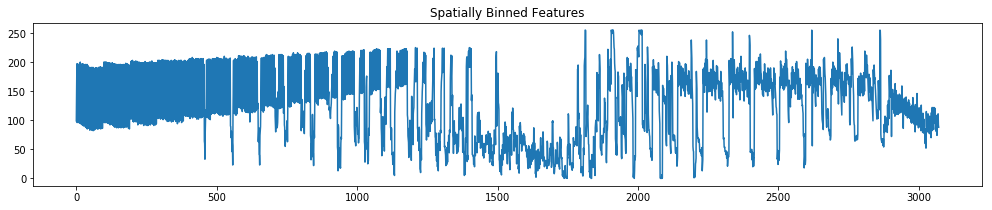

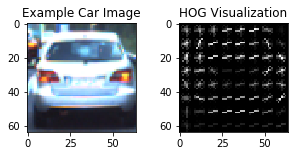

In [14]:
# Load image
image = mpimg.imread('test_images/test1.jpg')

# Draw test boxes
boxes = [((100, 100), (200, 200)), ((300, 100), (400, 200))]
result = draw_boxes(image, boxes)
plot(image, result, "Sample Boxes Drawn")

# Get color features
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot
if rh is not None:
    fig = plt.figure(figsize=(15, 3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    
# Get spatial features
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot
fig = plt.figure(figsize=(17, 3))
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

# Get HOG features
image = mpimg.imread('test_images/31.png')
orient = 9
pix_per_cell = 8
cell_per_block = 2
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# Plot color spaces
scale = max(image.shape[0], image.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(image, (np.int(image.shape[1] / scale), np.int(image.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting
#plot3d(img_small_RGB, img_small_rgb)
#plt.show()
#plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
#plt.show()

## Read in our training data

In [4]:
# Read in our vehicles and non-vehicles
images = glob.glob('./train_data_small/**/*.*', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
print( "Number of cars: " + str( len( cars ) ) )
print( "Number of non-cars: " + str( len( notcars ) ) )


Number of cars: 1198
Number of non-cars: 1125


### Create window sliding functions

In [5]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

In [6]:
# Define a function you will pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,
                            color_space = color_space, 
                            spatial_size = spatial_size,
                            hist_bins = hist_bins, 
                            orient = orient,
                            pix_per_cell = pix_per_cell, 
                            cell_per_block = cell_per_block, 
                            hog_channel = hog_channel,
                            spatial_feat = spatial_feat, 
                            hist_feat = hist_feat,
                            hog_feat = hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        reshaped_features = np.array(features).reshape(1, -1)
        test_features = scaler.transform(reshaped_features)
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    #8) Return windows for positive detections
    return on_windows

## Extract features from training data

In [ ]:
# Extract
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
#notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))

# Plot
fig = plt.figure(figsize=(17, 3))
plt.plot(car_features[0])
plt.title('Features')

# Create an array stack of feature vectors
#X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Plot an example of raw and scaled features
car_ind = np.random.randint(0, len(cars)) # Pick a random car
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()


## Create our classifier

In [16]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Train!
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts    : ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Test on image
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

NameError: name 'scaled_X' is not defined

In [17]:
# Define pipeline
def pipel(image):

    # Generate two layers of windows
    windows = []
    windows.append(slide_window(image, x_start_stop=[None, None], y_start_stop=[int(0.5  * image.shape[0]), None],
                           xy_window=(100, 100), xy_overlap=(0.5, 0.5)))
    windows.append(slide_window(image, x_start_stop=[None, None], y_start_stop=[int(0.75 * image.shape[0]), None],
                           xy_window=(200, 200), xy_overlap=(0.5, 0.5)))

    # Set extraction params
    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = False # HOG features on or off

    # Detect in those windows
    hot_windows = search_windows(image, windows, svc, X_scaler,
                            color_space = color_space, 
                            spatial_size = spatial_size,
                            hist_bins = hist_bins, 
                            orient = orient,
                            pix_per_cell = pix_per_cell, 
                            cell_per_block = cell_per_block, 
                            hog_channel = hog_channel,
                            spatial_feat = spatial_feat, 
                            hist_feat = hist_feat,
                            hog_feat = hog_feat)
    return hot_windows

# Run
hot_windows = pipel(image)

# Draw those windows
window_img = draw_boxes(draw_image, hot_windows, colour=(0, 200, 0), thickness=6)

# Show
plt.imshow(window_img)

NameError: name 'svc' is not defined

In [ ]:
# Define pipeline 
def pipeline( image ):
    
    hot_windows = pipel( image )

    # Draw those windows
    result = draw_boxes(image, hot_windows, colour=(0, 250, 0), thickness=5)                    

    return result

In [ ]:
# Create video
create_video( pipeline, "test_video.mp4", "test_output.mp4" )

# Show video
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format( "test_output.mp4" ))

In [ ]:
# Create video
create_video( pipeline, "project_video.mp4", "project_output.mp4" )

# Show video
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format( "project_output.mp4" ))